# Análise Multi-tarefa em Visão Computacional: Dataset UTKFace

## Introdução Técnica

Implementação de uma **rede neural convolucional multi-tarefa** para predição simultânea de idade, gênero e etnia a partir de imagens faciais.

- **Multi-task Learning (MTL)**: Aprendizado simultâneo de múltiplas tarefas relacionadas
- **Feature Sharing**: Compartilhamento de representações entre tarefas
- **Hard Parameter Sharing**: Arquitetura onde camadas iniciais são compartilhadas

![](lab_images/multtask.png)


## Dataset UTKFace

![](lab_images/image.png)

**Referência**: [https://susanqq.github.io/UTKFace/](https://susanqq.github.io/UTKFace/)

O dataset UTKFace contém mais de 20.000 imagens faciais com anotações de idade, gênero e etnia. A nomenclatura segue o padrão:

`[idade]_[gênero]_[raça]_[timestamp].jpg`

**Onde:**
- **Idade**: 0-116 anos (regressão)
- **Gênero**: 0=Masculino, 1=Feminino (classificação binária)
- **Etnia**: 0=Branco, 1=Negro, 2=Asiático, 3=Indiano, 4=Outros (classificação multi-classe)

**Exemplo**: `9_1_4_20170103213057382.jpg.chip.jpg`
- Idade: 9 anos
- Gênero: 1 (Feminino)
- Etnia: 4 (Outros)


In [ ]:
# Download e extração do dataset UTKFace
print("Baixando dataset UTKFace...")
# !wget https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip
# !jar xf UTKFace.zip

!curl -O https://hydranets-data.s3.eu-west-3.amazonaws.com/UTKFace.zip
!unzip UTKFace.zip

print("Dataset UTKFace baixado e extraído com sucesso!")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  125M  100  125M    0     0  5883k      0  0:00:21  0:00:21 --:--:-- 7053k 922k  0:00:27  0:00:08  0:00:19 5940k
Archive:  UTKFace.zip
   creating: UTKFace/
  inflating: __MACOSX/._UTKFace      
  inflating: UTKFace/9_1_2_20161219204347420.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._9_1_2_20161219204347420.jpg.chip.jpg  
  inflating: UTKFace/36_0_1_20170117163203851.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._36_0_1_20170117163203851.jpg.chip.jpg  
  inflating: UTKFace/86_1_0_20170120225751953.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._86_1_0_20170120225751953.jpg.chip.jpg  
  inflating: UTKFace/26_1_0_20170116171048641.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._26_1_0_20170116171048641.jpg.chip.jpg  
  inflating: UTKFace/1_1_2_20161219154612988.jpg.chip.jpg  
  inflating: __MACOSX/UTKFace/._1_1_2_201612191546129

Primeira imagem: UTKFace/100_0_0_20170112213500903.jpg.chip.jpg
Última imagem: UTKFace/9_1_4_20170103213057382.jpg.chip.jpg
Total de imagens: 23707


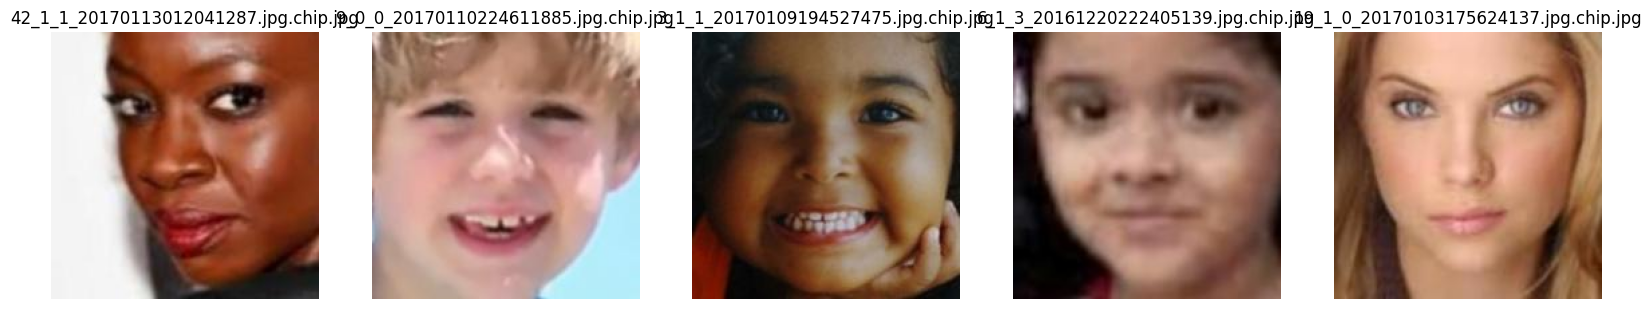

In [37]:
import os
import glob
import random
from PIL import Image
import matplotlib.pyplot as plt

# Obter a lista de caminhos de imagem
image_paths = sorted(glob.glob("UTKFace/*.jpg.chip.jpg"))

print(f"Primeira imagem: {image_paths[0]}")
print(f"Última imagem: {image_paths[-1]}")
print(f"Total de imagens: {len(image_paths)}")

# Selecionar algumas imagens aleatórias
num_images_to_show = 5
random_image_paths = random.sample(image_paths, num_images_to_show)

# Visualizar imagens aleatórias
fig, axes = plt.subplots(1, num_images_to_show, figsize=(20, 5))
for i, img_path in enumerate(random_image_paths):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(os.path.basename(img_path))

plt.show()


In [38]:
import os
import pandas as pd

# Labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []
ethnicity_labels = []

BASE_DIR = 'UTKFace'


# varre todas as imagens criando os rotulos
for filename in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    if len(temp) == 4:  # para garantir que split está correto
        try:
            age = int(temp[0])
            gender = int(temp[1])
            ethnicity = int(temp[2].split('.')[0])
            
            image_paths.append(image_path)
            age_labels.append(age)
            gender_labels.append(gender)
            ethnicity_labels.append(ethnicity)
        except ValueError:
            continue  # Skip se estiver nomeado errado

# Converte para DataFrame
df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels,
    'gender': gender_labels,
    'ethnicity': ethnicity_labels
})
df.head()




image  age  gender  ethnicity
0   UTKFace/9_1_2_20161219204347420.jpg.chip.jpg    9       1          2
1  UTKFace/36_0_1_20170117163203851.jpg.chip.jpg   36       0          1
2  UTKFace/86_1_0_20170120225751953.jpg.chip.jpg   86       1          0
3  UTKFace/26_1_0_20170116171048641.jpg.chip.jpg   26       1          0
4   UTKFace/1_1_2_20161219154612988.jpg.chip.jpg    1       1          2

### Um leve entendimento dos dados

- Distribuição das classes
- Qualidade das imagens
- Possíveis vieses no dataset
- Correlações entre variáveis target

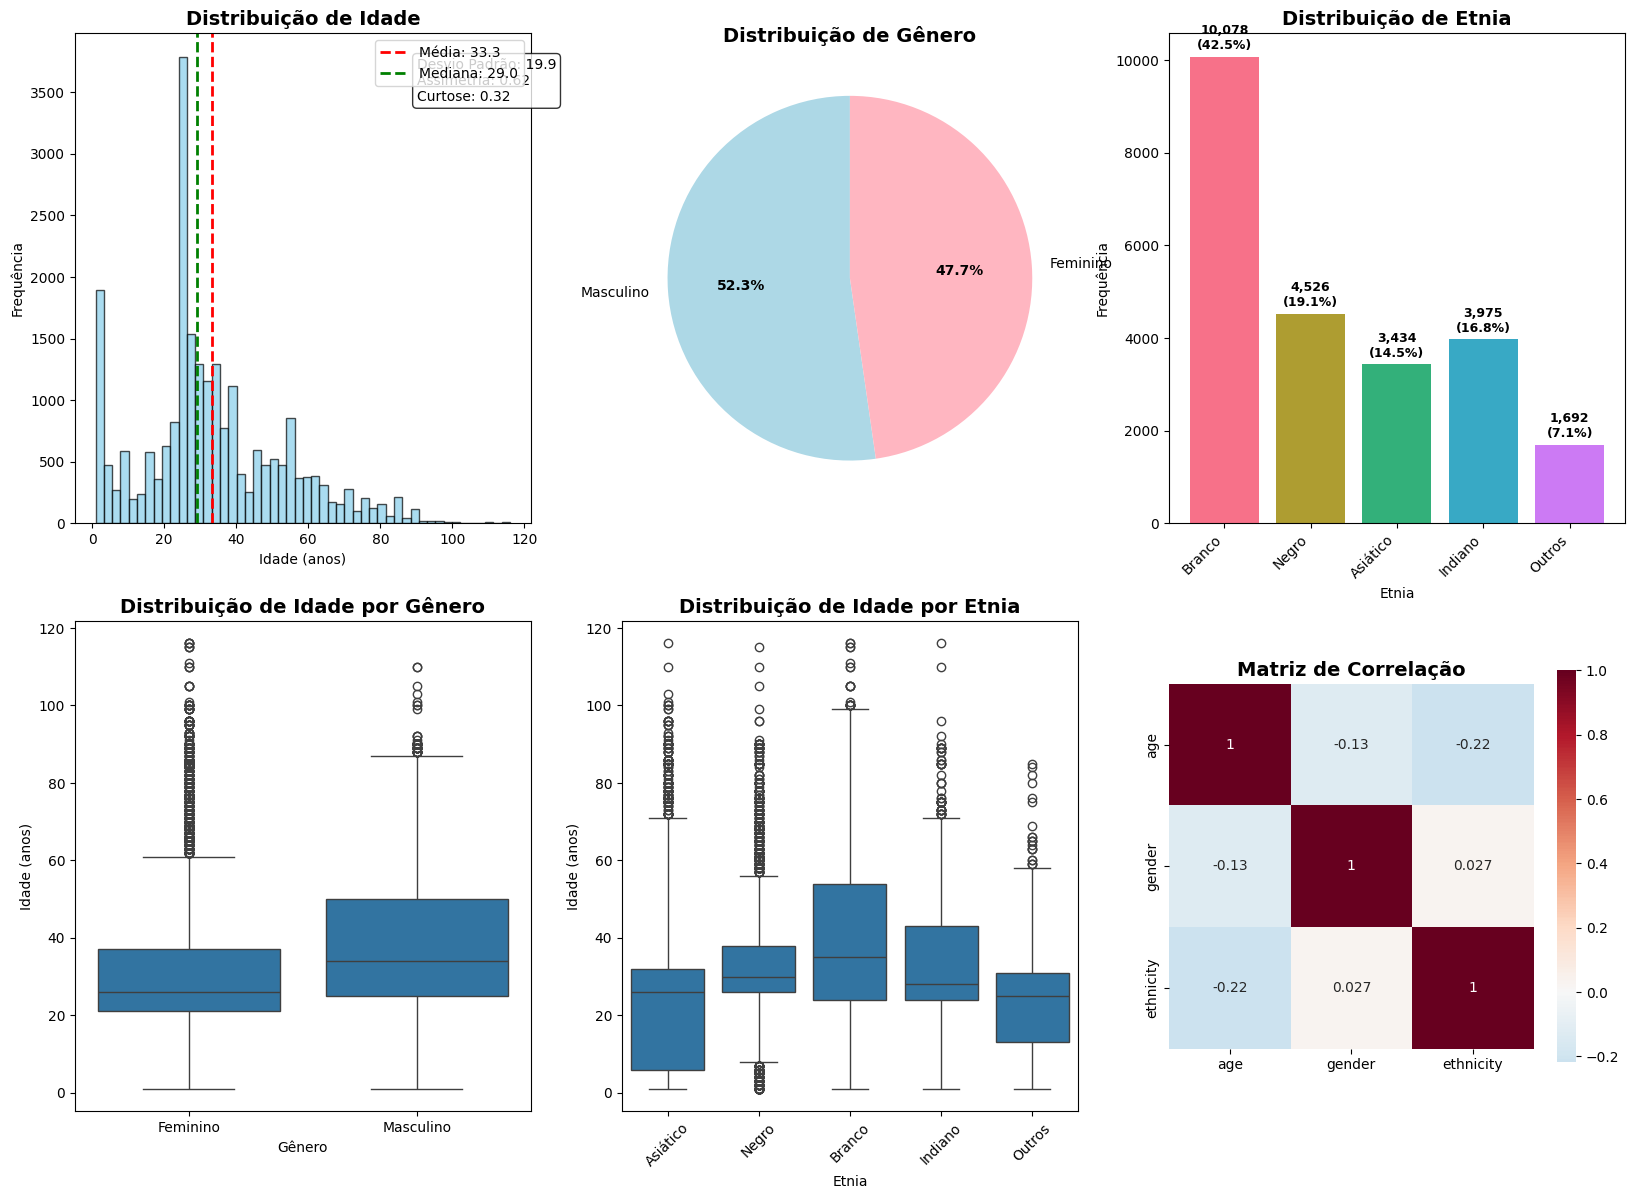

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Análise de distribuições com visualizações
fig, axes = plt.subplots(2, 3, figsize=(20, 14))

# Distribuição de idade
axes[0,0].hist(df['age'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribuição de Idade', fontweight='bold', fontsize=14)
axes[0,0].set_xlabel('Idade (anos)')
axes[0,0].set_ylabel('Frequência')

# Adicionar estatísticas no gráfico
mean_age = df['age'].mean()
median_age = df['age'].median()
std_age = df['age'].std()

axes[0,0].axvline(mean_age, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_age:.1f}')
axes[0,0].axvline(median_age, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_age:.1f}')
axes[0,0].legend()

# Adicionar texto com estatísticas
stats_text = f'Desvio Padrão: {std_age:.1f}\nAssimetria: {df["age"].skew():.2f}\nCurtose: {df["age"].kurtosis():.2f}'
axes[0,0].text(0.75, 0.95, stats_text, transform=axes[0,0].transAxes, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                verticalalignment='top', fontsize=10)

# Distribuição de gênero
gender_counts = df['gender'].value_counts()
gender_labels = ['Masculino', 'Feminino']
colors = ['lightblue', 'lightpink']

wedges, texts, autotexts = axes[0,1].pie(gender_counts.values, labels=gender_labels, 
                                        autopct='%1.1f%%', startangle=90, colors=colors)
axes[0,1].set_title('Distribuição de Gênero', fontweight='bold', fontsize=14)

# Melhorar aparência do texto
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontweight('bold')

# Distribuição de etnia
ethnicity_counts = df['ethnicity'].value_counts().sort_index()
ethnicity_labels = ['Branco', 'Negro', 'Asiático', 'Indiano', 'Outros']
colors_eth = sns.color_palette("husl", len(ethnicity_counts))

bars = axes[0,2].bar(range(len(ethnicity_counts)), ethnicity_counts.values, color=colors_eth)
axes[0,2].set_title('Distribuição de Etnia', fontweight='bold', fontsize=14)
axes[0,2].set_xlabel('Etnia')
axes[0,2].set_ylabel('Frequência')
axes[0,2].set_xticks(range(len(ethnicity_labels)))
axes[0,2].set_xticklabels(ethnicity_labels, rotation=45, ha='right')

# Adicionar valores e percentuais nas barras
total = sum(ethnicity_counts.values)
for bar, count in zip(bars, ethnicity_counts.values):
    percentage = (count / total) * 100
    axes[0,2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(ethnicity_counts)*0.01,
                    f'{count:,}\n({percentage:.1f}%)', ha='center', va='bottom', 
                    fontweight='bold', fontsize=9)

# Box plot: Idade por gênero
df_viz = df.copy()
df_viz['gender_label'] = df_viz['gender'].map({0: 'Masculino', 1: 'Feminino'})

sns.boxplot(data=df_viz, x='gender_label', y='age', ax=axes[1,0])
axes[1,0].set_title('Distribuição de Idade por Gênero', fontweight='bold', fontsize=14)
axes[1,0].set_xlabel('Gênero')
axes[1,0].set_ylabel('Idade (anos)')

# Box plot: Idade por etnia
df_viz['ethnicity_label'] = df_viz['ethnicity'].map({
    0: 'Branco', 1: 'Negro', 2: 'Asiático', 3: 'Indiano', 4: 'Outros'
})

sns.boxplot(data=df_viz, x='ethnicity_label', y='age', ax=axes[1,1])
axes[1,1].set_title('Distribuição de Idade por Etnia', fontweight='bold', fontsize=14)
axes[1,1].set_xlabel('Etnia')
axes[1,1].set_ylabel('Idade (anos)')
axes[1,1].tick_params(axis='x', rotation=45)

# 2.6 Matriz de correlação
correlation_matrix = df[['age', 'gender', 'ethnicity']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, ax=axes[1,2], cbar_kws={'shrink': 0.8})
axes[1,2].set_title('Matriz de Correlação', fontweight='bold', fontsize=14)

plt.show()


## preparando os dados para o treinamento

In [40]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

print(f"Tamanho dos dados de treino: {len(train_df)}")

print(f"Tamanho dos dados de teste: {len(test_df)}")


print(train_df.head())

Tamanho dos dados de treino: 16593
Tamanho dos dados de teste: 7112
                                               image  age  gender  ethnicity
9680   UTKFace/24_1_3_20170119170547814.jpg.chip.jpg   24       1          3
15478  UTKFace/54_0_0_20170119201455775.jpg.chip.jpg   54       0          0
1330   UTKFace/51_0_1_20170117190816460.jpg.chip.jpg   51       0          1
14898  UTKFace/10_0_4_20170103201924664.jpg.chip.jpg   10       0          4
14193  UTKFace/45_0_1_20170117140113412.jpg.chip.jpg   45       0          1


In [41]:

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split


# def bloco_convolucional(x, filters, kernel_size=(3, 3), pool_size=(2, 2)):
#     """Função auxiliar para criar um bloco convolucional com normalização e pooling."""
#     x = Conv2D(filters, kernel_size, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = MaxPooling2D(pool_size)(x)
#     return x

# x = bloco_convolucional(input_img, 32)  # bloco 1
# x = bloco_convolucional(x, 64)  # bloco 2
# x = bloco_convolucional(x, 128)  # bloco 3

# Definir a entrada
# extrator de características
input_img = Input(shape=(128, 128, 3))  # image size

# bloco 1
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# bloco 2
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# bloco 3
x = Conv2D(128, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.5)(x)  # Adicionando dropout para regularização

# Definindo as saídas da rede
age_output = Dense(1, name='age')(x) # regressao nao tem função de ativação
gender_output = Dense(1, activation='sigmoid', name='gender')(x) # binário function de ativação sigmoid
ethnicity_output = Dense(5, activation='softmax', name='ethnicity')(x) # multiclassificação função de ativação softmax

# Criando o modelo
model = Model(inputs=input_img, outputs=[age_output, gender_output, ethnicity_output])


# Compilando o modelo
model.compile(
    optimizer='adam',
    loss={'age': 'mean_squared_error', 
          'gender': 'binary_crossentropy', 
          'ethnicity': 'sparse_categorical_crossentropy'},
    metrics={'age': 'mae', 
             'gender': 'accuracy', 
             'ethnicity': 'accuracy'}
)





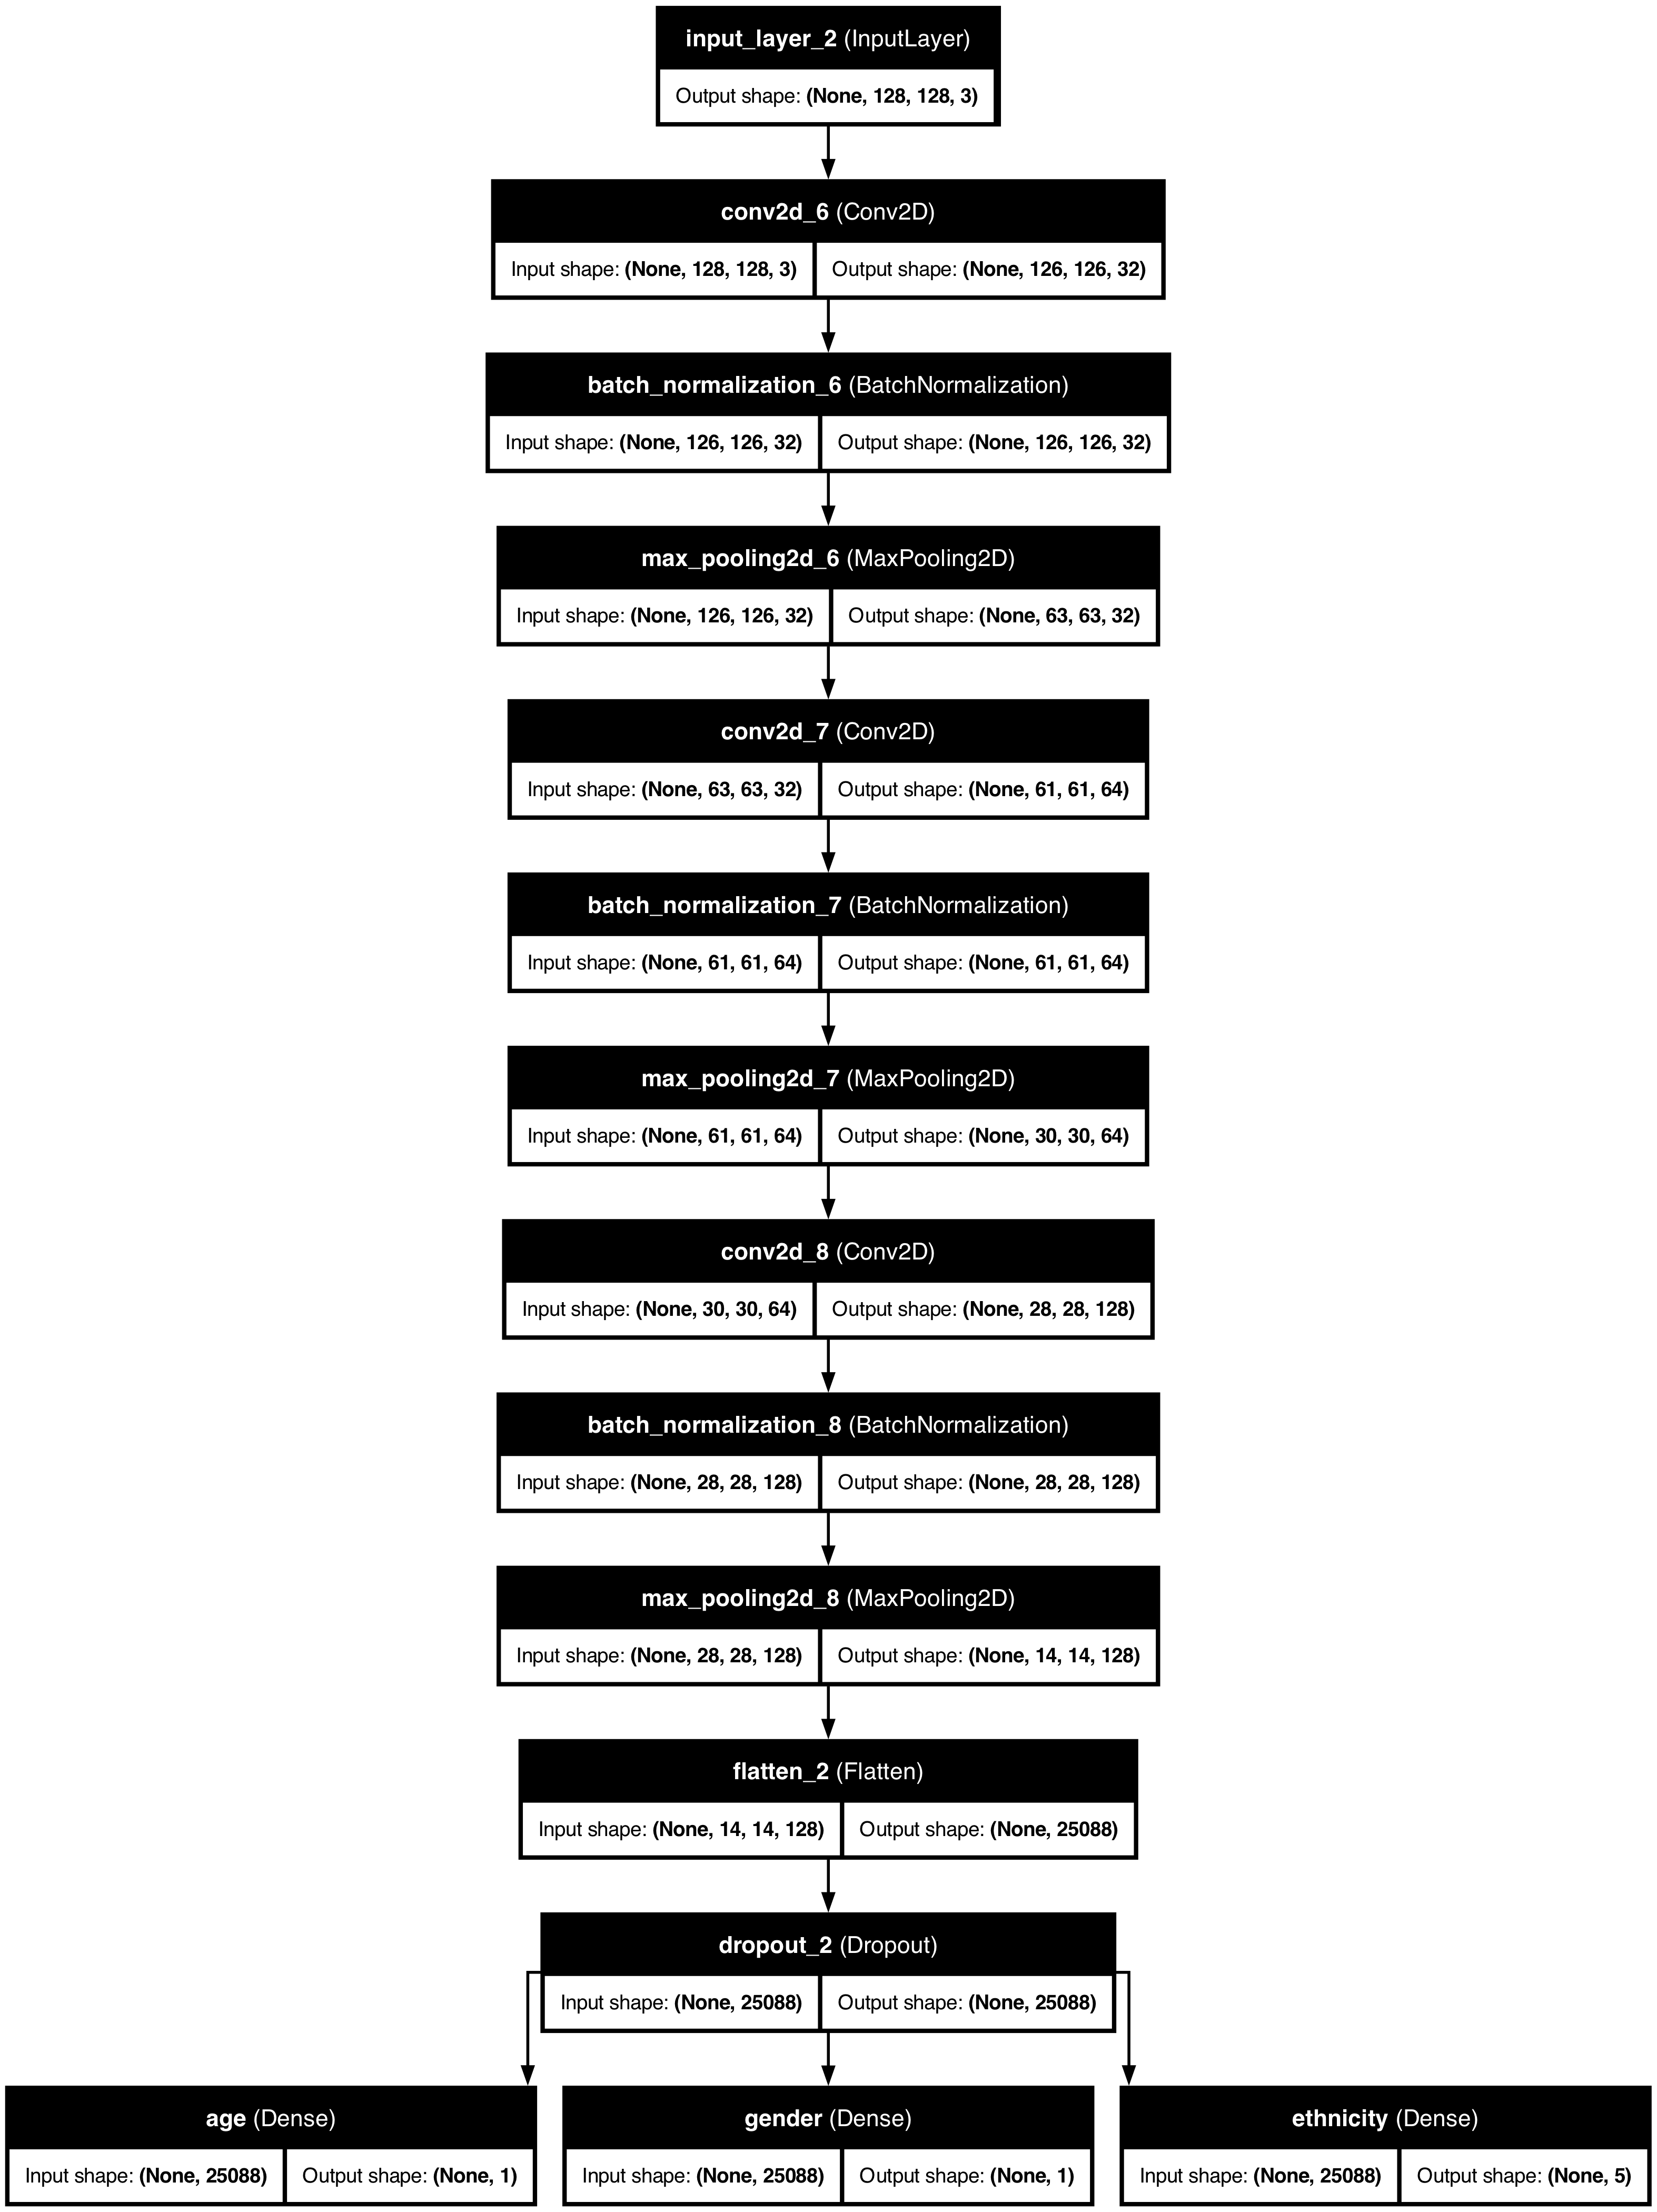

In [42]:
from tensorflow.keras.utils import plot_model

# Gerar a imagem da arquitetura do modelo
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


## Preparando o pipeline de dados com `tf.data.Dataset`

O TensorFlow fornece a API `tf.data` para criar pipelines de dados altamente eficientes e personalizáveis. No nosso caso, estamos utilizando essa API para carregar, transformar, embaralhar, e preparar as imagens para o treinamento da rede neural.


### Etapas do Pipeline

```
┌─────────────┐    ┌──────────┐    ┌───────┐    ┌─────────┐    ┌───────┐    ┌─────────┐
│ File Paths  │───▶│   Map    │───▶│ Cache │───▶│ Shuffle │───▶│ Batch │───▶│Prefetch │───▶ Model
│ (Metadata)  │    │(Load+PP) │    │       │    │         │    │       │    │         │
└─────────────┘    └──────────┘    └───────┘    └─────────┘    └───────┘    └─────────┘
```


### Etapas do pipeline:

```python
train_data = tf.data.Dataset.from_tensor_slices(dict(train_df))
```

- Cria um dataset inicial a partir de um DataFrame (como train_df) transformado em dicionário.
- Cada amostra terá, por exemplo, uma chave "path" com o caminho da imagem e "label" com a idade.

```python
train_data = train_data.map(load_and_preprocess_from_path_label, num_parallel_calls=tf.data.AUTOTUNE)
```
- O uso de `num_parallel_calls=tf.data.AUTOTUNE` permite paralelismo automático para acelerar a etapa de mapeamento.

```python
train_data = train_data.cache().shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
```

- .cache() guarda os dados processados na memória (ou disco), evitando recarregar toda hora.

- .shuffle(1000) embaralha os dados (importante para evitar overfitting por ordem fixa).

- .batch(batch_size) agrupa os dados em lotes para treinamento.

- .prefetch(tf.data.AUTOTUNE) permite ao pipeline preparar o próximo lote enquanto o modelo está treinando, maximizando a performance.

As referências são: 
- [https://www.tensorflow.org/guide/data](https://www.tensorflow.org/guide/data)
- [https://igormintz.medium.com/introduction-to-tensorflows-data-dataset-api-83d49f300740](https://igormintz.medium.com/introduction-to-tensorflows-data-dataset-api-83d49f300740)


In [43]:

# função para pré-processar as imagens
def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])  # Reduced image size
    image = image / 255.0
    return image

def load_and_preprocess_from_path_label(data):
    return load_and_preprocess_image(data['image']), (data['age'], data['gender'], data['ethnicity'])

# Cria o dataset a partir do Dataframe
batch_size = 8  # tamanho do batch

train_data = tf.data.Dataset.from_tensor_slices(dict(train_df)) # cria o dataset a partir do DataFrame
train_data = train_data.map(load_and_preprocess_from_path_label, num_parallel_calls=tf.data.experimental.AUTOTUNE) # mapear as imagens e rótulos com
train_data = train_data.cache().shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices(dict(test_df))
test_data = test_data.map(load_and_preprocess_from_path_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_data = test_data.cache().batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



In [44]:
# Treina o modelo  simples
history = model.fit(
    train_data,
    epochs=2,
    validation_data=test_data
)

# Salva o modelo
# model.save('modelo.h5')

Epoch 1/2
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 143s 68ms/step - age_loss: 277.1752 - age_mae: 12.7690 - ethnicity_accuracy: 0.5328 - ethnicity_loss: 5.3385 - gender_accuracy: 0.7499 - gender_loss: 1.3579 - loss: 283.8716 - val_age_loss: 1325.5953 - val_age_mae: 31.6659 - val_ethnicity_accuracy: 0.5219 - val_ethnicity_loss: 4.3577 - val_gender_accuracy: 0.7650 - val_gender_loss: 1.4535 - val_loss: 1331.4049
Epoch 2/2
 854/2075 ━━━━━━━━━━━━━━━━━━━━ 1:21 67ms/step - age_loss: 176.5784 - age_mae: 10.3841 - ethnicity_accuracy: 0.6384 - ethnicity_loss: 5.1338 - gender_accuracy: 0.8157 - gender_loss: 1.1699 - loss: 182.8823

KeyboardInterrupt: 

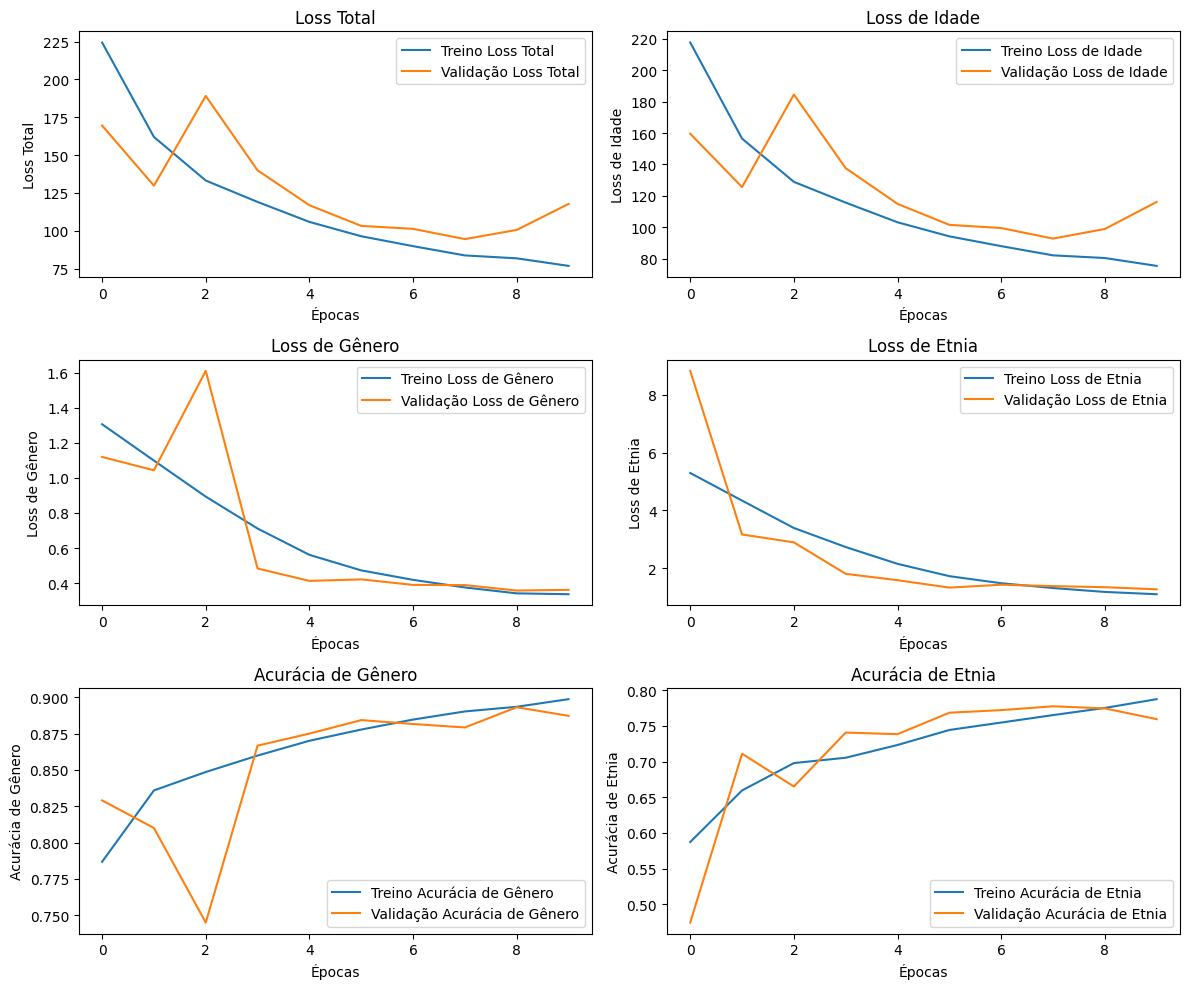

In [32]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    metrics = {
        'Loss Total': ['loss', 'val_loss'],
        'Loss de Idade': ['age_loss', 'val_age_loss'],
        'Loss de Gênero': ['gender_loss', 'val_gender_loss'],
        'Loss de Etnia': ['ethnicity_loss', 'val_ethnicity_loss'],
        'Acurácia de Gênero': ['gender_accuracy', 'val_gender_accuracy'],
        'Acurácia de Etnia': ['ethnicity_accuracy', 'val_ethnicity_accuracy']
    }

    plt.figure(figsize=(12, 10))

    for i, (title, keys) in enumerate(metrics.items()):
        plt.subplot(3, 2, i+1)
        plt.plot(history.history[keys[0]], label=f'Treino {title}')
        plt.plot(history.history[keys[1]], label=f'Validação {title}')
        plt.xlabel('Épocas')
        plt.ylabel(title)
        plt.legend()
        plt.title(title)

    plt.tight_layout()
    plt.show()

# curvas de treinamento
plot_training_curves(history)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


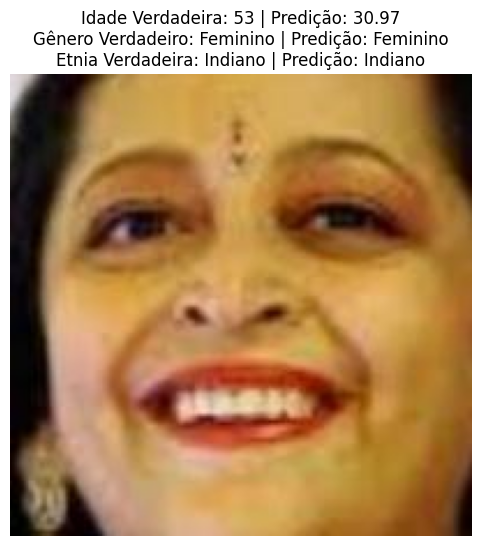

In [53]:
import tensorflow as tf
import numpy as np

model = tf.keras.models.load_model('model/modelo.h5')

def load_and_preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])  # Tamanho da imagem conforme usado no treinamento
    image = image / 255.0
    return image

def make_prediction(model, df, index=0):
    # Obter o caminho da imagem e os rótulos verdadeiros
    image_path = df.iloc[index]['image']
    age_true = df.iloc[index]['age']
    gender_true = df.iloc[index]['gender']
    ethnicity_true = df.iloc[index]['ethnicity']

    # Carregar e preprocessar a imagem
    image = load_and_preprocess_image(image_path)
    image = tf.expand_dims(image, axis=0)  # Adicionar dimensão do batch

    # Fazer a predição
    age_pred, gender_pred, ethnicity_pred = model.predict(image)
    predicted_age = age_pred[0][0]
    predicted_gender = 'Masculino' if gender_pred[0][0] < 0.5 else 'Feminino'
    predicted_ethnicity = np.argmax(ethnicity_pred[0])

    # Classes de etnia (ajuste conforme necessário)
    ethnicity_classes = ["Branco", "Negro", "Asiático", "Indiano", "Outros"]

    # Visualizar a imagem com predições
    plt.figure(figsize=(6, 6))
    plt.imshow(plt.imread(image_path))
    plt.axis('off')
    plt.title(f"Idade Verdadeira: {age_true} | Predição: {predicted_age:.2f}\n"
              f"Gênero Verdadeiro: {'Masculino' if gender_true == 0 else 'Feminino'} | Predição: {predicted_gender}\n"
              f"Etnia Verdadeira: {ethnicity_classes[ethnicity_true]} | Predição: {ethnicity_classes[predicted_ethnicity]}")
    plt.show()

# faz predições
numero_imagem = 2022
make_prediction(model, test_df, index= numero_imagem)




In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Definindo callbacks para o treinamento

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,min_lr=0.0001, verbose=1)

# Callbacks
callbacks = [checkpoint, early_stop, reduce_lr]


In [ ]:
# # Treina o modelo
history = model.fit(
    train_data,
    epochs=300,
    validation_data=test_data,
    callbacks=callbacks
)



# # Salva o modelo
# model.save('modelo.h5')